In [ ]:
import torch
torch.__version__


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pytorch_utils.callbacks import MyLrFinder,RecordMetric
from pytorch_utils.trainer import learn
from pytorch_utils.hooks import hook_context_manager
from collections import OrderedDict


import torchvision
import torch
from torchvision import transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import Module
from torchvision import models
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

/opt/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
cifar_train_norm_stats = ((0.49139968,  0.48215841,  0.44653091), (0.2023, 0.1994, 0.2010))

trfms = {}
trfms['train'] = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),                                
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(*cifar_train_norm_stats),
                                    ])

trfms['val'] = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(*cifar_train_norm_stats),
                ])

BATCH_SIZE = 100

dataset = {}
dataloader = {}
for phase in ['train','val']:
    train_bool = True if phase == 'train' else False
    dataset[phase] = CIFAR10(root='./data', train = train_bool, download=True, transform=trfms[phase])
    dataloader[phase] = DataLoader(dataset[phase], batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

data = {}
data['ds'] = dataset
data['dl'] = dataloader
data['tfms'] = trfms
data['classes'] = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
data['norm_stats'] = cifar_train_norm_stats
data['maping'] = data['ds']['train'].class_to_idx


Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(f"Train Data size : {len(data['ds']['train'])}")
print(f"Train Data size : {len(data['ds']['val'])}")

Train Data size : 50000
Train Data size : 10000


In [6]:
def transfer_learning_model(model_original, data):
    
    class Pooling_Layers(Module):
        '''Create Pooling layers'''
        def __init__(self):
            super().__init__()
            self.AdpAvgPool = nn.AdaptiveAvgPool2d((1,1))
            self.AdpMaxPool = nn.AdaptiveMaxPool2d((1,1))

        def forward(self, x):
            return torch.cat((self.AdpAvgPool(x), self.AdpMaxPool(x)), dim = 1)

    class Flatten_4D_2D(Module):
        '''Flatten'''
        def __init__(self):
            super().__init__()

        def forward(self,x):
            return x.view(x.size(0),-1)

    def FC_layers(in_features, inter_features = 512, p = 0.5, number_classes = 2):
        '''Fully connected layers: in_features->inter_features->number_classes'''
        layers = OrderedDict()
        layers['BatchNorm'] =  nn.BatchNorm1d(num_features=in_features)
        layers['Dropout'] = nn.Dropout(p = p/2)

        layers['FC1'] = nn.Linear(in_features, inter_features)
        layers['FC1 RELU']  = nn.ReLU(inplace=True)
        layers['FC1 BatchNorm']  = nn.BatchNorm1d(inter_features)
        layers['FC1 Dropout'] = nn.Dropout(p)

        layers['FC2'] = nn.Linear(inter_features, number_classes)
#         layers['Softmax'] = nn.LogSoftmax(dim = 1)
        return nn.Sequential(layers)


    # Freeze all the layers in the original_model
    for param in model_original.parameters():
        param.requires_grad = False

    base = list(model_original.named_children())[:-2] # remove last two layers
    base.append(('Pooling Layers', Pooling_Layers())) # add pooling layers
    base.append(('Flatten', Flatten_4D_2D())) # add flatten layers
    base_pooling_flatten = nn.Sequential(OrderedDict(base)) # create a temp model

    # calculate the output of temp model with dummy image batch
    with hook_context_manager(base_pooling_flatten) as hook:
        # Take the first two images from the batch
        dummy_img_batch = next(iter(data['dl']['train']))[0][:2,...]
        _ = base_pooling_flatten(dummy_img_batch)

    output_features_size = hook.output_shape[1]
    
    # Add Fully Connected layers
    base.append(('Fully Connected',FC_layers(in_features = output_features_size, number_classes = len(data['classes']))))

    transfer_learn_model = nn.Sequential(OrderedDict(base))
    
    return transfer_learn_model

In [7]:
net = transfer_learning_model(models.resnet34(pretrained = False), data)


In [8]:
    
optimizer = optim.SGD(net.parameters(), lr=1E-5, momentum=0.9, weight_decay=1e-4)    
criterion = nn.CrossEntropyLoss()
testlearner = learn(data, net, optimizer,criterion)
testlearner.unfreeze(num_layers = -1)

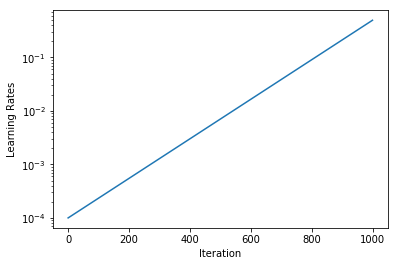

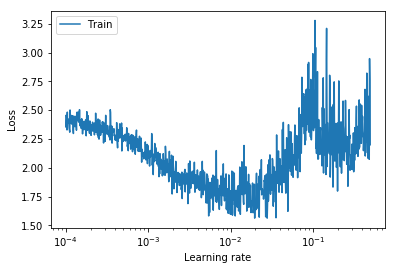

In [9]:
testlearner.lr_finder(epochs = 2, start_lr = 1E-4, stop_lr = 0.5)

In [10]:
net = transfer_learning_model(models.resnet34(pretrained = False), data)

In [24]:
!rm -r '../Checkpoints'    

Epoch:1 | train Loss: 0.73 | Metric : 74.448
Epoch:1 | val Loss: 0.73 | Metric : 75.050
Saving to ../Checkpoints/checkpoint.pth
-------------------------


Epoch:2 | train Loss: 0.74 | Metric : 74.004
Epoch:2 | val Loss: 0.75 | Metric : 73.770
-------------------------


Epoch:3 | train Loss: 0.76 | Metric : 73.354
Epoch:3 | val Loss: 0.75 | Metric : 73.900
-------------------------


Epoch:4 | train Loss: 0.78 | Metric : 72.712
Epoch:4 | val Loss: 0.80 | Metric : 72.190
-------------------------


Epoch:5 | train Loss: 0.76 | Metric : 73.544
Epoch:5 | val Loss: 0.76 | Metric : 73.350
-------------------------


Epoch:6 | train Loss: 0.71 | Metric : 75.308
Epoch:6 | val Loss: 0.69 | Metric : 76.330
Saving to ../Checkpoints/checkpoint.pth
-------------------------


Epoch:7 | train Loss: 0.67 | Metric : 76.732
Epoch:7 | val Loss: 0.67 | Metric : 76.990
Saving to ../Checkpoints/checkpoint.pth
-------------------------


Epoch:8 | train Loss: 0.63 | Metric : 77.902
Epoch:8 | val Loss: 0.64 | Metric : 78.430
Saving to ../Checkpoints/checkpoint.pth
-------------------------


Epoch:9 | train Loss: 0.62 | Metric : 78.348
Epoch:9 | val Loss: 0.65 | Metric : 77.820
-------------------------


Epoch:10 | train Loss: 0.63 | Metric : 77.818
Epoch:10 | val Loss: 0.68 | Metric : 76.610
-------------------------


Epoch:11 | train Loss: 0.66 | Metric : 77.102
Epoch:11 | val Loss: 0.70 | Metric : 76.240
-------------------------


Epoch:12 | train Loss: 0.68 | Metric : 76.316
Epoch:12 | val Loss: 0.76 | Metric : 74.120
-------------------------


Epoch:13 | train Loss: 0.66 | Metric : 77.032
Epoch:13 | val Loss: 0.68 | Metric : 76.330
-------------------------


Epoch:14 | train Loss: 0.63 | Metric : 78.036
Epoch:14 | val Loss: 0.65 | Metric : 77.640
-------------------------


Epoch:15 | train Loss: 0.59 | Metric : 79.644
Epoch:15 | val Loss: 0.62 | Metric : 78.480
Saving to ../Checkpoints/checkpoint.pth
-------------------------


Epoch:16 | train Loss: 0.55 | Metric : 80.814
Epoch:16 | val Loss: 0.60 | Metric : 79.520
Saving to ../Checkpoints/checkpoint.pth
-------------------------


Epoch:17 | train Loss: 0.53 | Metric : 81.362
Epoch:17 | val Loss: 0.61 | Metric : 78.850
-------------------------


Epoch:18 | train Loss: 0.56 | Metric : 80.436
Epoch:18 | val Loss: 0.63 | Metric : 78.320
-------------------------


Epoch:19 | train Loss: 0.58 | Metric : 79.874
Epoch:19 | val Loss: 0.66 | Metric : 77.680
-------------------------


Epoch:20 | train Loss: 0.60 | Metric : 78.884
Epoch:20 | val Loss: 0.66 | Metric : 77.160
-------------------------


Epoch:21 | train Loss: 0.60 | Metric : 79.106
Epoch:21 | val Loss: 0.64 | Metric : 77.890
-------------------------


Epoch:22 | train Loss: 0.56 | Metric : 80.492
Epoch:22 | val Loss: 0.61 | Metric : 79.120
-------------------------


Epoch:23 | train Loss: 0.52 | Metric : 81.738
Epoch:23 | val Loss: 0.59 | Metric : 80.130
Saving to ../Checkpoints/checkpoint.pth
-------------------------


Epoch:24 | train Loss: 0.48 | Metric : 83.148
Epoch:24 | val Loss: 0.57 | Metric : 80.530
Saving to ../Checkpoints/checkpoint.pth
-------------------------


Epoch:25 | train Loss: 0.47 | Metric : 83.564
Epoch:25 | val Loss: 0.59 | Metric : 79.500
-------------------------


Epoch:26 | train Loss: 0.49 | Metric : 82.940
Epoch:26 | val Loss: 0.62 | Metric : 79.040
-------------------------


Epoch:27 | train Loss: 0.52 | Metric : 81.744
Epoch:27 | val Loss: 0.67 | Metric : 77.540
-------------------------


Epoch:28 | train Loss: 0.54 | Metric : 81.078
Epoch:28 | val Loss: 0.68 | Metric : 77.650
-------------------------


Epoch:29 | train Loss: 0.54 | Metric : 81.168
Epoch:29 | val Loss: 0.61 | Metric : 78.870
-------------------------


Epoch:30 | train Loss: 0.51 | Metric : 82.342
Epoch:30 | val Loss: 0.60 | Metric : 79.930
-------------------------


Epoch:31 | train Loss: 0.46 | Metric : 84.022
Epoch:31 | val Loss: 0.57 | Metric : 80.820
Saving to ../Checkpoints/checkpoint.pth
-------------------------


Epoch:32 | train Loss: 0.43 | Metric : 84.854
Epoch:32 | val Loss: 0.56 | Metric : 81.350
Saving to ../Checkpoints/checkpoint.pth
-------------------------


Epoch:33 | train Loss: 0.42 | Metric : 85.592
Epoch:33 | val Loss: 0.57 | Metric : 81.080
-------------------------


Epoch:34 | train Loss: 0.44 | Metric : 84.422
Epoch:34 | val Loss: 0.59 | Metric : 80.120
-------------------------


Epoch:35 | train Loss: 0.47 | Metric : 83.682
Epoch:35 | val Loss: 0.62 | Metric : 79.380
-------------------------


Epoch:36 | train Loss: 0.50 | Metric : 82.590
Epoch:36 | val Loss: 0.64 | Metric : 78.180
-------------------------


Epoch:37 | train Loss: 0.49 | Metric : 82.764
Epoch:37 | val Loss: 0.60 | Metric : 80.110
-------------------------


Epoch:38 | train Loss: 0.46 | Metric : 83.952
Epoch:38 | val Loss: 0.60 | Metric : 80.080
-------------------------


Epoch:39 | train Loss: 0.42 | Metric : 85.244
Epoch:39 | val Loss: 0.57 | Metric : 81.410
Saving to ../Checkpoints/checkpoint.pth
-------------------------


Epoch:40 | train Loss: 0.39 | Metric : 86.402
Epoch:40 | val Loss: 0.56 | Metric : 81.640
Saving to ../Checkpoints/checkpoint.pth
-------------------------


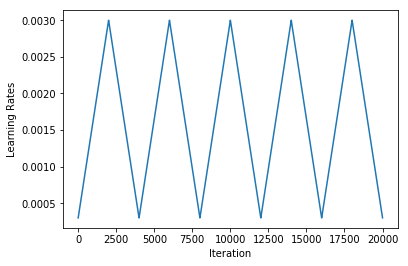

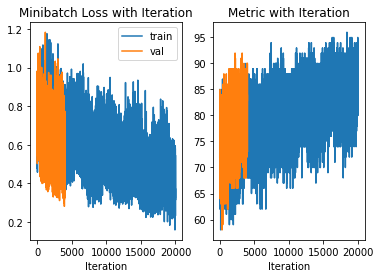

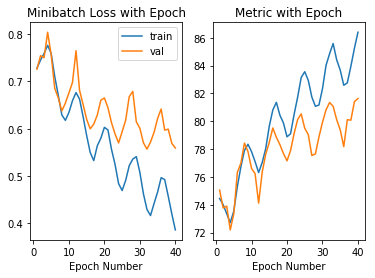

In [26]:
optimizer = optim.SGD(net.parameters(), lr=1E-5, momentum=0.9, weight_decay=1e-4, nesterov=True)    
#optimizer = optim.Adam(net.parameters(), lr=6E-3, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
testlearner = learn(data, net, optimizer,criterion)
epochs = 40
iterations_per_epoch = len(testlearner.data['dl']['train'])
stepsize = 4 * iterations_per_epoch
testlearner.unfreeze(num_layers = -1)
testlearner.cyclic_lr(epochs, 0.3E-3, 0.3E-2, stepsize, policy = 'triangular')

[autoreload of pytorch_utils.trainer failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 374, in superreload
    module = reload(module)
  File "/opt/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/jupyter/.local/lib/python3.6/site-packa

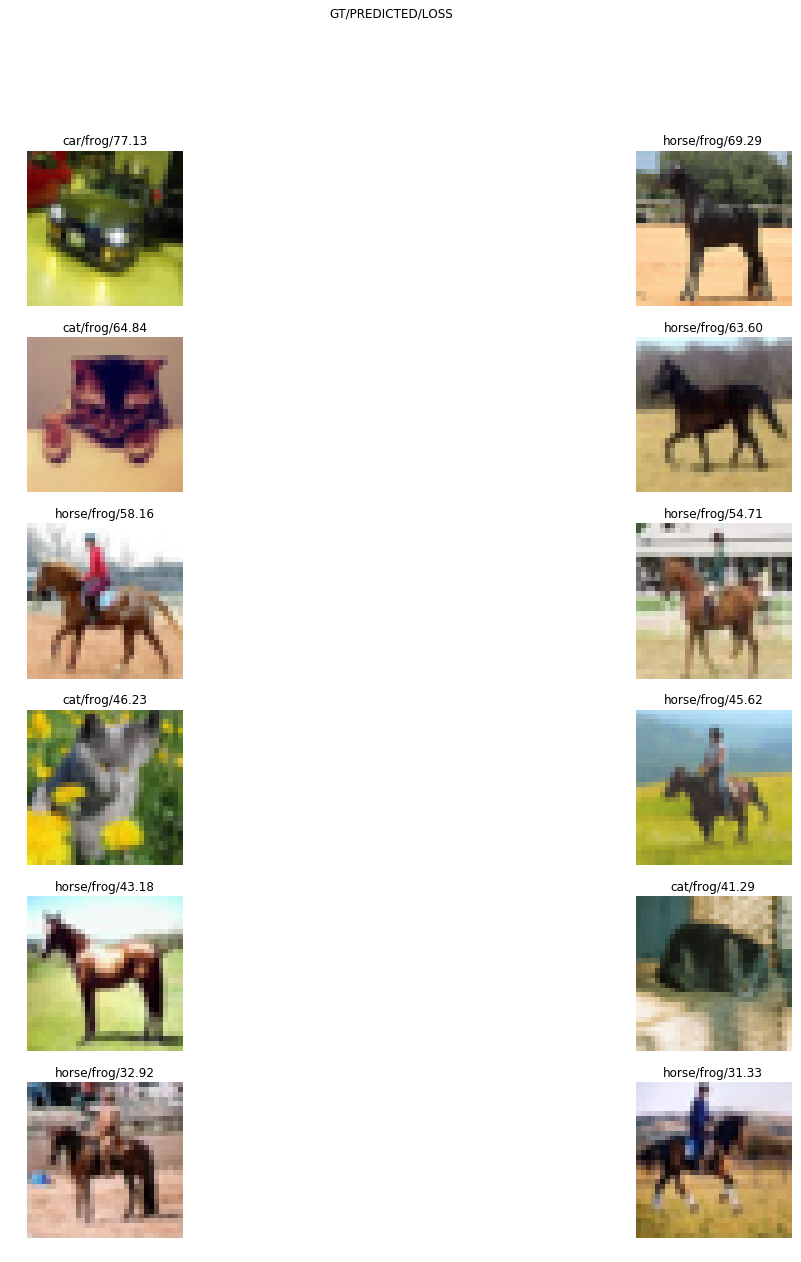

In [11]:
inference = testlearner.get_predictions(data)

In [ ]:
net = resnet_transfer_model()
optimizer = optim.Adam(net.parameters(), lr=1E-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
testlearner = learn(data, net, optimizer,criterion)
testlearner.record_metric(10)




Text(0,0.5,'LearningRate')

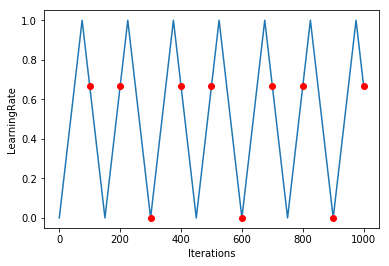

In [4]:
import matplotlib.pyplot as plt

train_dataset_length = 500
batch_size = 5
total_epochs = 10
start_lr = 0
end_lr= 1

iterations_per_epoch = int(train_dataset_length/batch_size) #100
total_iterations = int(total_epochs * iterations_per_epoch)
stepsize =  75 # expressed in iterations

lr=[]

for iteration in range(total_iterations+1):
    cycle = int((iteration/(2*stepsize)))
    x = abs((iteration - (2*cycle+1)*stepsize)/stepsize)
    lr.append(start_lr + (end_lr-start_lr)* max([0,1-x]))


plt.plot(range(total_iterations+1), lr)
epochs = range(iterations_per_epoch,total_iterations+iterations_per_epoch,iterations_per_epoch)
plt.plot(epochs, lr[iterations_per_epoch:total_iterations+iterations_per_epoch:iterations_per_epoch],'ro')
plt.xlabel('Iterations')
plt.ylabel('LearningRate')

Total Iterations: 1000


Text(0,0.5,'LearningRate')

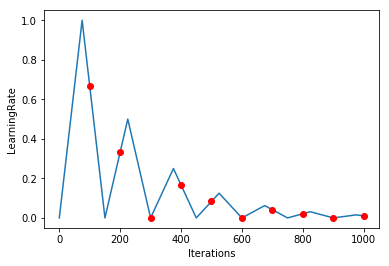

In [2]:
import matplotlib.pyplot as plt

train_dataset_length = 500
batch_size = 5
total_epochs = 10

iterations_per_epoch = int(train_dataset_length/batch_size) #100
total_iterations = int(total_epochs * iterations_per_epoch)
stepsize =  75 # expressed in iterations

lr=[]
start_lr = 0
end_lr= 1
print(f"Total Iterations: {total_iterations}")

for iteration in range(total_iterations+1):
    cycle = int((iteration/(2*stepsize)))
    x = abs((iteration - (2*cycle+1)*stepsize)/stepsize)
    lr.append(start_lr + (end_lr-start_lr)* min([1, max([0,1-x])/2**cycle]))

plt.plot(range(total_iterations+1), lr)
epochs = range(iterations_per_epoch,total_iterations+iterations_per_epoch,iterations_per_epoch)
plt.plot(epochs, lr[iterations_per_epoch:total_iterations+iterations_per_epoch:iterations_per_epoch],'ro')
plt.xlabel('Iterations')
plt.ylabel('LearningRate')



In [19]:
dir(net)

['__call__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_item_by_idx',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_slow_forward',
 '_state_dict_hooks',
 '_tracing_name',
 '_version',
 'add_module',
 'apply',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'ha

In [106]:
for childname, child in net.named_parameters():
    print(child.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
